# Facial Emotion Recognition 

### 1) Import Libraries

In [1]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image
from tensorflow.keras.utils import plot_model
import random

### 2) Data 

In [2]:
# path to train/test datasets
train_path = './improved_archive/train/'
test_path = './improved_archive/test/'

# image paramaters
IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 128

# class labels
classes = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']


In [3]:
# data augmentation
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   featurewise_center = False,
                                   featurewise_std_normalization = False,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)

test_datagen  = ImageDataGenerator(rescale = 1. / 255)

In [4]:
train_generator  = train_datagen.flow_from_directory(directory = train_path,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE)

Found 28710 images belonging to 7 classes.
Found 7218 images belonging to 7 classes.


#### Exploratory Data Analysis

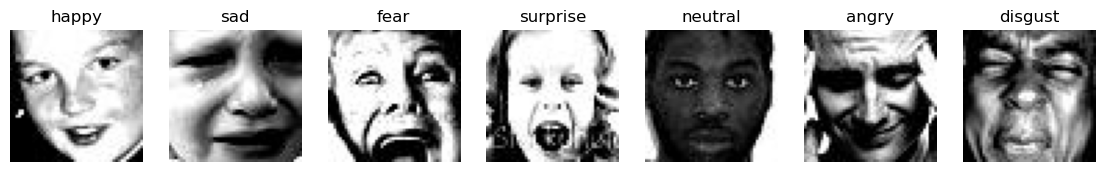

In [5]:
# visualizing emotion examples
plt.figure(figsize = (14,22))
i = 1
for emotion in os.listdir(train_path):
    if emotion != '.DS_Store':
        img = load_img((train_path + emotion +'/'+ os.listdir(train_path + emotion)[2]))
        plt.subplot(1,7,i)
        plt.imshow(img)
        plt.title(emotion)
        plt.axis('off')
        i += 1
plt.show()

In [6]:
# counting number of images for each emotion in the test/train datasets
def count_labels(path, name):
    dict_emo = {}
    for emotion in os.listdir(path):
        if emotion != '.DS_Store':
            folder = path + emotion
            dict_emo[emotion] = len(os.listdir(folder))
    df = pd.DataFrame(dict_emo, index = [name])
    return df

train_count = count_labels(train_path, 'train')
test_count = count_labels(test_path, 'test')

pd.concat([train_count, test_count])

,happy,sad,fear,surprise,neutral,angry,disgust
train,7216,4830,4097,3171,4965,3995,436
test,1775,1248,1025,832,1233,959,112


In [7]:
# printng class labels and corresponding indices
class_labels = test_generator.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
# checking image shape
train_sample = next(train_generator)
print(train_sample[0].shape)

(128, 48, 48, 3)


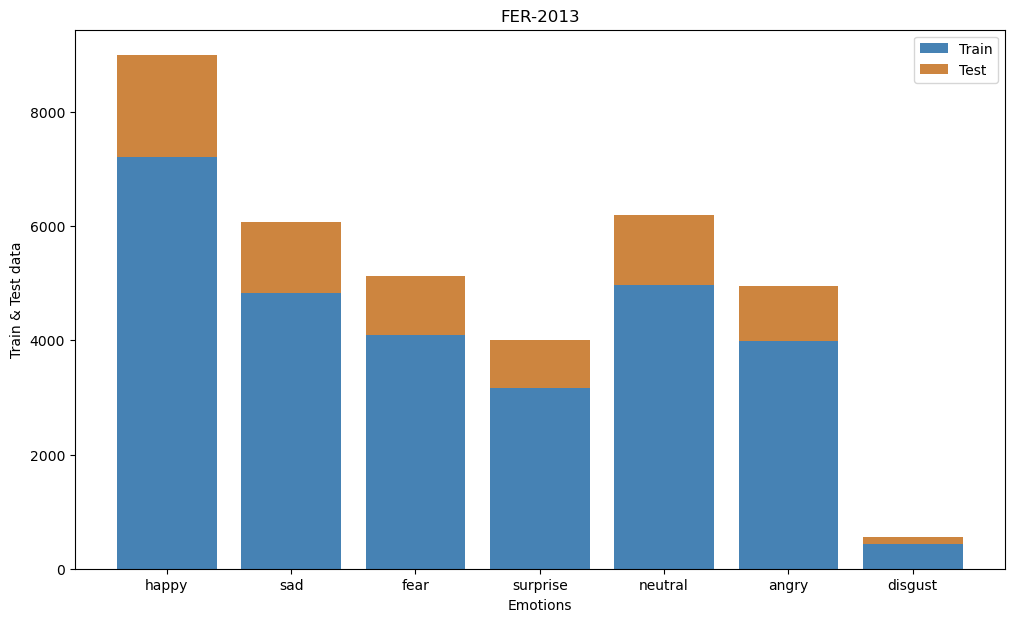

In [9]:
# visualizing train/test data distribution
x = list(test_count.columns)
y1 = train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize = (12,7))

ax = plt.axes()
ax.set_facecolor('white')
plt.bar(x, y1, color = 'steelblue')
plt.bar(x, y2, bottom = y1, color = 'peru')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc = 'upper right')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

## 3) MODELS

#### 3.1 Model Configurations

In [10]:
# model parameters

PATIENCE = 8
LEARNING_RATE = 0.0001
EPOCHS = 100

counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()} 
update_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
early_stopping = EarlyStopping(verbose = 1, patience = PATIENCE + 10)

In [11]:
# function to determine the f1_score for each epoch as tf.keras.metrics does not have that ability
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1_val


METRICS = [
      tf.keras.metrics.BinaryAccuracy(name = 'Accuracy'),
      tf.keras.metrics.Precision(name = 'Precision'),
      tf.keras.metrics.Recall(name = 'Recall'),  
      tf.keras.metrics.AUC(name = 'AUC'),
      f1_score
]

2022-12-01 18:05:41.697101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3.2.1 Model 1: CNN

In [12]:
model_CNN = Sequential()

# 1st CNN layer
model_CNN.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,3)))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size = (2,2)))
model_CNN.add(Dropout(0.25))

# 2nd CNN layer
model_CNN.add(Conv2D(128,(5,5),padding = 'same'))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size = (2,2)))
model_CNN.add(Dropout (0.25))

# 3rd CNN layer
model_CNN.add(Conv2D(512,(3,3),padding = 'same'))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size = (2,2)))
model_CNN.add(Dropout (0.25))

# 4th CNN layer
model_CNN.add(Conv2D(512,(3,3), padding = 'same'))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size = (2, 2)))
model_CNN.add(Dropout(0.25))

# 5th CNN layer
model_CNN.add(Conv2D(512,(5,5), padding = 'same'))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size = (2, 2)))
model_CNN.add(Dropout(0.25))

model_CNN.add(Flatten())

# Fully connected 1st layer
model_CNN.add(Dense(256))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(Dropout(0.25))


# 2nd Fully connected layer
model_CNN.add(Dense(512))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(Dropout(0.25))

model_CNN.add(Dense(7, activation = 'softmax'))

optimizer = Adam(learning_rate = 0.0001)
model_CNN.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = METRICS)
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

### 3.2.2 Model Training and Evaluation


In [13]:
model_check_point_CNN = ModelCheckpoint('model_CNN.h5')

history_CNN = model_CNN.fit(train_generator,
                  validation_data = test_generator,
                  epochs = EPOCHS,
                  verbose = 1,
                  callbacks = [update_learning_rate, model_check_point_CNN, early_stopping], 
                  class_weight = class_weights)

Epoch 1/100
225/225 [==============================] - 477s 2s/step - loss: 3.9067 - Accuracy: 0.8447 - Precision: 0.1763 - Recall: 0.0238 - AUC: 0.5216 - f1_score: 0.0416 - val_loss: 2.0369 - val_Accuracy: 0.8571 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.4862 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - 445s 2s/step - loss: 3.7351 - Accuracy: 0.8490 - Precision: 0.2081 - Recall: 0.0203 - AUC: 0.5468 - f1_score: 0.0366 - val_loss: 1.9527 - val_Accuracy: 0.8571 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.5629 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - 442s 2s/step - loss: 3.6146 - Accuracy: 0.8509 - Precision: 0.2381 - Recall: 0.0200 - AUC: 0.5662 - f1_score: 0.0366 - val_loss: 1.9784 - val_Accuracy: 0.8571 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.5469 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/100
2

### 3.2.3 Saving the model

In [14]:
model_CNN.save('model_CNN.h5')

### 3.2.4 Visulaizing Results

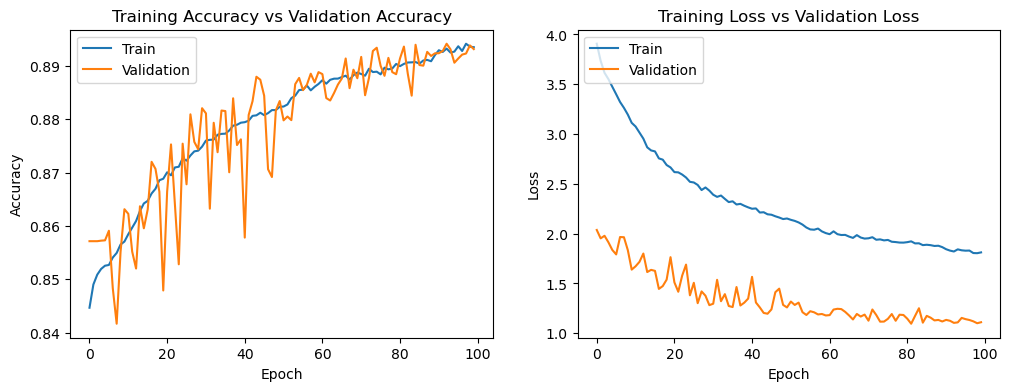

In [16]:
fig , ax = plt.subplots(1,2)
train_acc = history_CNN.history['Accuracy']
train_loss = history_CNN.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history_CNN.history['Accuracy'])
ax[0].plot(history_CNN.history['val_Accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc = 'upper left')

ax[1].plot(history_CNN.history['loss'])
ax[1].plot(history_CNN.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc = 'upper left')

plt.show()

In [17]:
# Evaluate

train_evalation = model_CNN.evaluate(train_generator)
test_evaluation = model_CNN.evaluate(test_generator)

metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns = ['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores:\n')
df

57/57 [==============================] - 28s 498ms/step - loss: 1.1106 - Accuracy: 0.8932 - Precision: 0.6938 - Recall: 0.4514 - AUC: 0.8976 - f1_score: 0.5470


Model Scores:



,Metric Name,Train,Validate
0,Loss,1.037,1.111
1,Accuracy,0.899,0.893
2,Precision,0.737,0.694
3,Recall,0.455,0.451
4,Auc,0.910,0.898
5,F1_Score,0.562,0.547


In [ ]:
# Visualize

hs_CNN = history_CNN.history

acc = hs_CNN['Accuracy']
val_acc = hs_CNN['val_Accuracy']
loss =  hs_CNN['loss']
val_loss = hs_CNN['val_loss']
auc =  hs_CNN['AUC']
val_auc = hs_CNN['val_AUC']
precision =hs_CNN['Precision']
val_precision = hs_CNN['val_Precision']
f1 = hs_CNN['f1_score']
val_f1 = hs_CNN['val_f1_score']              

plt.style.use('ggplot')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize = (20,5))
fig.suptitle(" Plain CNN Model Metrics Visualization ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

In [27]:
# confusion matrix

y_true = test_generator.classes
y_pred =  model_CNN.predict(test_generator)
y_pred = tf.argmax(y_pred, axis = 1).numpy()

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

print(cm)

57/57 [==============================] - 36s 641ms/step
              precision    recall  f1-score   support

           0       0.14      0.13      0.13       968
           1       0.01      0.04      0.02       112
           2       0.16      0.06      0.09      1032
           3       0.25      0.22      0.23      1780
           4       0.17      0.28      0.21      1233
           5       0.17      0.11      0.14      1261
           6       0.11      0.16      0.13       832

    accuracy                           0.17      7218
   macro avg       0.15      0.14      0.14      7218
weighted avg       0.18      0.17      0.16      7218

[[124  49  55 220 256 119 145]
 [ 16   5   7  24  32   8  20]
 [132  38  63 217 317 106 159]
 [231  90  82 386 504 196 291]
 [157  50  87 238 350 150 201]
 [122  56  63 295 364 144 217]
 [102  47  42 169 233 108 131]]


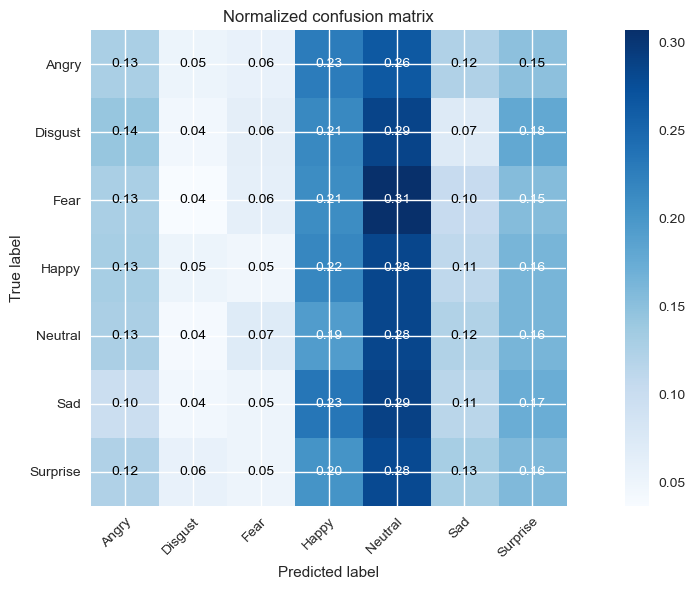

In [28]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
ax.figure.colorbar(im, ax = ax)

ax.set(xticks = np.arange(cm.shape[1]),
       yticks = np.arange(cm.shape[0]),
       xticklabels = classes, yticklabels = classes,
       title = 'Normalized confusion matrix',
       ylabel = 'True label',
       xlabel = 'Predicted label')

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode = "anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha = "center", va = "center",
                color = "white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# Testing and Prediction

(48, 48, 1)


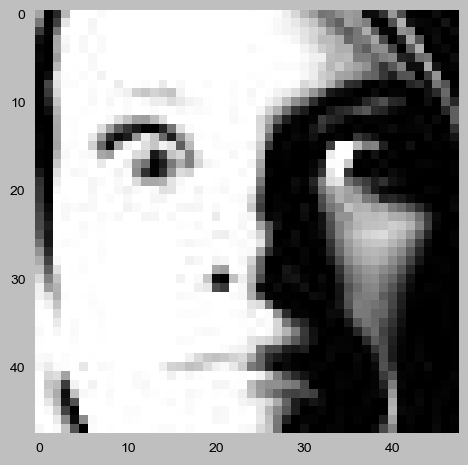

In [29]:
plt.style.use('grayscale')
plt.grid(visible = None)
img_path = './improved_archive/test/fear/PrivateTest_31388255.jpg'
test_image = image.load_img(img_path,target_size = IMAGE_SIZE,color_mode = 'grayscale')
test_image = image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

In [30]:
img = image.load_img(img_path,target_size = IMAGE_SIZE)
img = np.expand_dims(img, axis = 0)
print(img.shape)

(1, 48, 48, 3)


In [31]:
result=model_CNN.predict(img)
string_lst = [str(i) for i in result[0]]
lst = [x.lstrip('0') for x in string_lst]
final_preds = [];
for val in lst:
    if val == '.0':
        final_preds.append(0)
    else:
        char = val[0]
        final_preds.append(int(char))
        split_string = 'e'
        if split_string in val:
            res = val.split(split_string, 1)

1/1 [==============================] - 0s 100ms/step


In [32]:
y_pred = np.argmax(final_preds)
print(y_pred)
print(classes)
print('The person facial emotion is:', classes[y_pred])

2
['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
The person facial emotion is: Fear


## 3.3 Model 2: VGG 

In [33]:
# VGG16
# include_top set to false to allow for fine tuning for this dataset

base_model_VGG16 = tf.keras.applications.VGG16(input_shape = IMAGE_SHAPE,include_top = False,weights = "imagenet")
base_model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### 3.3.1 Freezing Layers


In [34]:
for layer in base_model_VGG16.layers[:11]:
    layer.trainable = False
print("Model trainable",len(base_model_VGG16.trainable_variables))

Model trainable 12


### 3.3.2 Adding Layers 

In [35]:
model_VGG16=Sequential()
model_VGG16.add(base_model_VGG16)
model_VGG16.add(BatchNormalization())
model_VGG16.add(Dropout(0.5))
model_VGG16.add(GaussianNoise(0.01))
model_VGG16.add(GlobalAveragePooling2D())

model_VGG16.add(Flatten())
model_VGG16.add(Dense(256, activation = 'relu',kernel_regularizer = regularizers.l2(0.001),bias_regularizer = regularizers.l2(0.001)))
model_VGG16.add(BatchNormalization())
model_VGG16.add(Dropout(0.5))

model_VGG16.add(Dense(128, activation = 'relu',kernel_regularizer = regularizers.l2(0.001),bias_regularizer = regularizers.l2(0.001)))
model_VGG16.add(BatchNormalization())
model_VGG16.add(Dropout(0.5))

model_VGG16.add(Dense(7, activation = "softmax"))

adam = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model_VGG16.compile(optimizer = adam, loss = 'categorical_crossentropy',metrics = METRICS)
model_VGG16.summary()
# need to get to output shape of [None, 7] for the 7 emotion classes

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization_7 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 1, 1, 512)         0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 1, 1, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                      

### 3.3.3 Model Training and Evaluation


In [36]:
# Run Model
model_check_point_VGG = ModelCheckpoint('model_VGG.h5')

history_VGG16 = model_VGG16.fit(train_generator,
                  validation_data = test_generator,
                  epochs = EPOCHS,
                  verbose = 1,
                  callbacks = [update_learning_rate, model_check_point_VGG, early_stopping], 
                  class_weight = class_weights)

Epoch 1/100
225/225 [==============================] - 434s 2s/step - loss: 5.5651 - Accuracy: 0.8279 - Precision: 0.3067 - Recall: 0.1626 - AUC: 0.6184 - f1_score: 0.1197 - val_loss: 2.8489 - val_Accuracy: 0.8287 - val_Precision: 0.3081 - val_Recall: 0.1597 - val_AUC: 0.6550 - val_f1_score: 0.2112 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - 432s 2s/step - loss: 4.9113 - Accuracy: 0.8231 - Precision: 0.2412 - Recall: 0.1112 - AUC: 0.5832 - f1_score: 0.1521 - val_loss: 5.4331 - val_Accuracy: 0.7660 - val_Precision: 0.1761 - val_Recall: 0.1733 - val_AUC: 0.4950 - val_f1_score: 0.1746 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - 432s 2s/step - loss: 4.5766 - Accuracy: 0.8335 - Precision: 0.2925 - Recall: 0.1166 - AUC: 0.6061 - f1_score: 0.1663 - val_loss: 7.1677 - val_Accuracy: 0.7672 - val_Precision: 0.1334 - val_Recall: 0.1146 - val_AUC: 0.4752 - val_f1_score: 0.1225 - lr: 1.0000e-04
Epoch 4/100
225/225 [============================

### 3.3.4 Saving the model

In [37]:
model_VGG16.save('model_VGG.h5')

### 3.3.5 Visulaizing Results

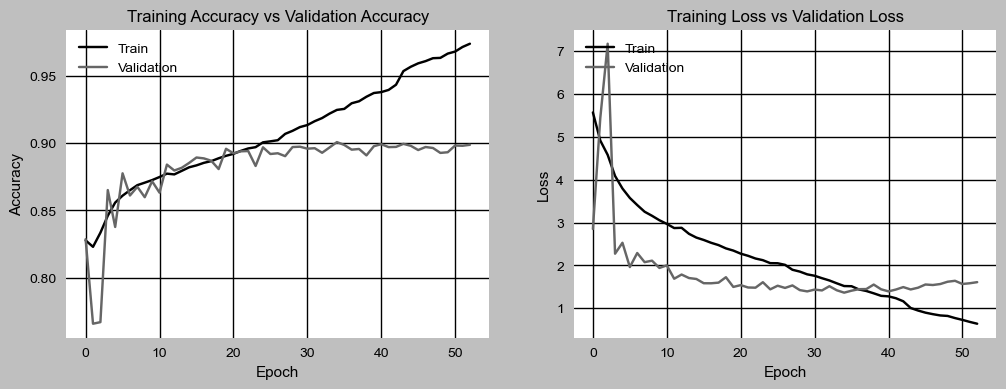

In [49]:
fig , ax = plt.subplots(1,2)
train_acc = history_VGG16.history['Accuracy']
train_loss = history_VGG16.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history_VGG16.history['Accuracy'])
ax[0].plot(history_VGG16.history['val_Accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc = 'upper left')

ax[1].plot(history_VGG16.history['loss'])
ax[1].plot(history_VGG16.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc = 'upper left')

plt.show()

In [39]:
# Evaluate
#  Some Scores of train & test set

train_evalation = model_VGG16.evaluate(train_generator)
test_evaluation = model_VGG16.evaluate(test_generator)

metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns = ['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores:\n')
df

57/57 [==============================] - 41s 714ms/step - loss: 1.6094 - Accuracy: 0.8987 - Precision: 0.6545 - Recall: 0.6162 - AUC: 0.8928 - f1_score: 0.6350


Model Scores:



,Metric Name,Train,Validate
0,Loss,0.425,1.609
1,Accuracy,0.977,0.899
2,Precision,0.932,0.655
3,Recall,0.908,0.616
4,Auc,0.994,0.893
5,F1_Score,0.920,0.635


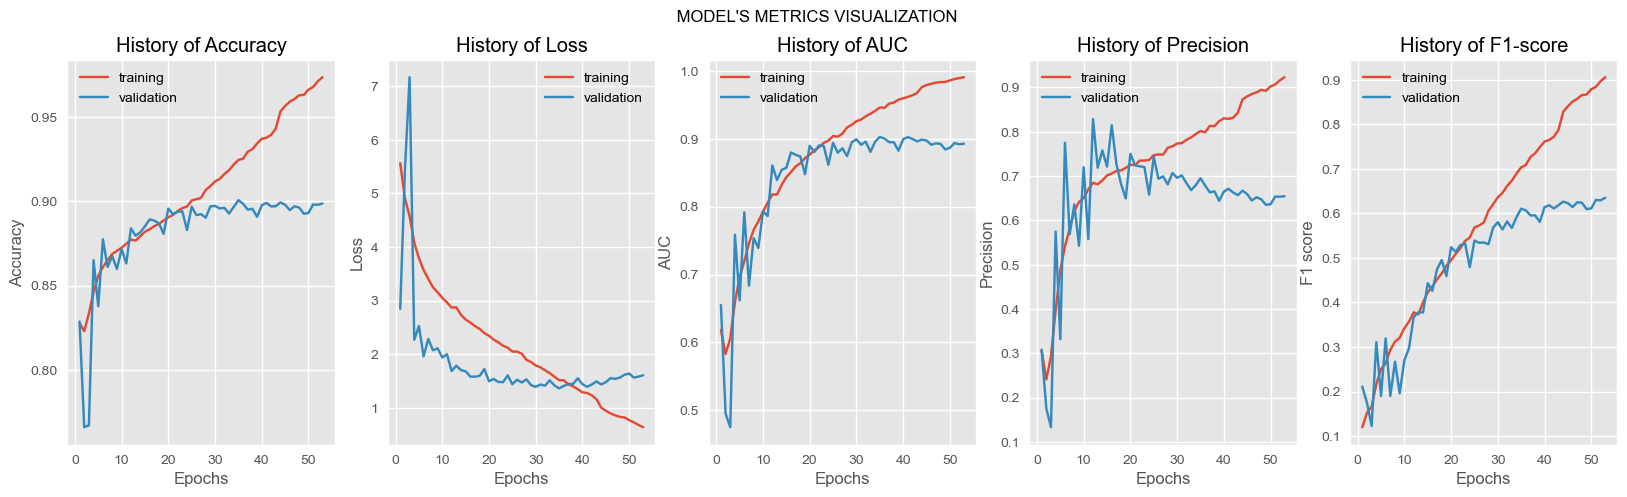

In [40]:
# Visualize

hs_VGG16 = history_VGG16.history

acc = hs_VGG16['Accuracy']
val_acc = hs_VGG16['val_Accuracy']
loss =  hs_VGG16['loss']
val_loss = hs_VGG16['val_loss']
auc =  hs_VGG16['AUC']
val_auc = hs_VGG16['val_AUC']
precision = hs_VGG16['Precision']
val_precision = hs_VGG16['val_Precision']
f1 = hs_VGG16['f1_score']
val_f1 = hs_VGG16['val_f1_score']              

plt.style.use('ggplot')

ax1.set(facecolor = "white")
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" VGG16 Model Metrics Visualization ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

In [41]:
# confusion matrix

y_true = test_generator.classes
y_pred =  model_VGG16.predict(test_generator)
y_pred = tf.argmax(y_pred, axis = 1).numpy()

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
print(cm)

57/57 [==============================] - 41s 710ms/step
              precision    recall  f1-score   support

           0       0.13      0.15      0.14       968
           1       0.01      0.01      0.01       112
           2       0.13      0.12      0.12      1032
           3       0.25      0.24      0.24      1780
           4       0.18      0.16      0.17      1233
           5       0.18      0.19      0.18      1261
           6       0.11      0.11      0.11       832

    accuracy                           0.17      7218
   macro avg       0.14      0.14      0.14      7218
weighted avg       0.17      0.17      0.17      7218

[[141  15 122 226 175 184 105]
 [ 16   1  19  18  18  26  14]
 [158   9 124 239 165 216 121]
 [301  23 248 424 259 331 194]
 [180  22 177 295 203 218 138]
 [185  14 189 289 199 241 144]
 [136  13 101 204 130 156  92]]


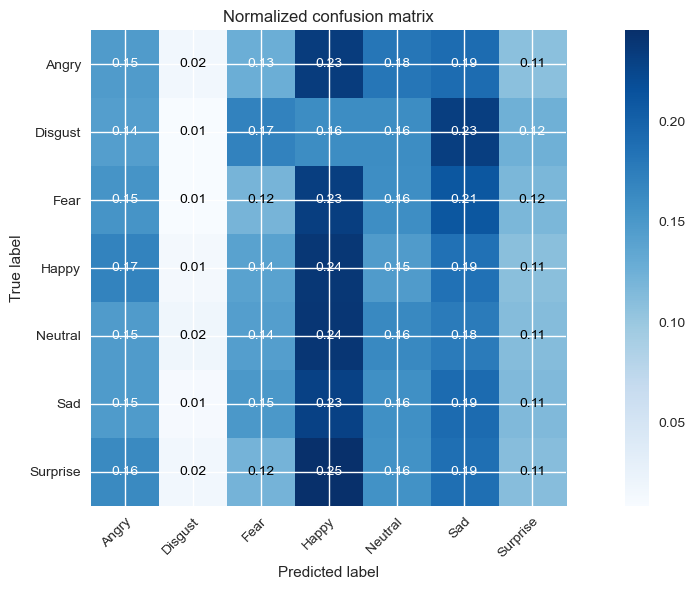

In [42]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
fig, ax = plt.subplots(figsize = (12,6))

im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
ax.figure.colorbar(im, ax = ax)

ax.set(xticks = np.arange(cm.shape[1]),
       yticks = np.arange(cm.shape[0]),
       xticklabels = classes, yticklabels = classes,
       title = 'Normalized confusion matrix',
       ylabel ='True label',
       xlabel ='Predicted label')

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode = "anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha = "center", va = "center",
                color = "white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# Testing Predictions

(48, 48, 1)


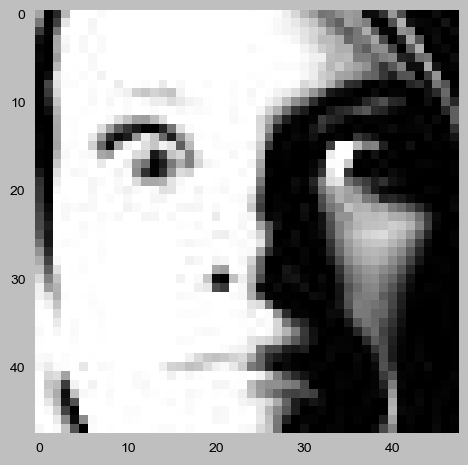

In [43]:
plt.style.use('grayscale')
plt.grid(visible = None)
img_path = './improved_archive/test/fear/PrivateTest_31388255.jpg'
test_image = image.load_img(img_path,target_size = IMAGE_SIZE,color_mode = 'grayscale')
test_image = image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

In [44]:
img = image.load_img(img_path,target_size = IMAGE_SIZE)
img = np.expand_dims(img, axis = 0)
print(img.shape)

(1, 48, 48, 3)


In [45]:
result=model_VGG16.predict(img)
string_lst = [str(i) for i in result[0]]
lst = [x.lstrip('0') for x in string_lst]
final_preds = [];
for val in lst:
    if val == '.0':
        final_preds.append(0)
    else:
        char = val[0]
        final_preds.append(int(char))
        split_string = 'e'
        if split_string in val:
            res = val.split(split_string, 1)

1/1 [==============================] - 0s 102ms/step


In [46]:
y_pred_vgg = np.argmax(final_preds)
print(y_pred_vgg)
print(classes)
print('The person facial emotion is:', classes[y_pred_vgg])

2
['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
The person facial emotion is: Fear


# Compairing Both Models

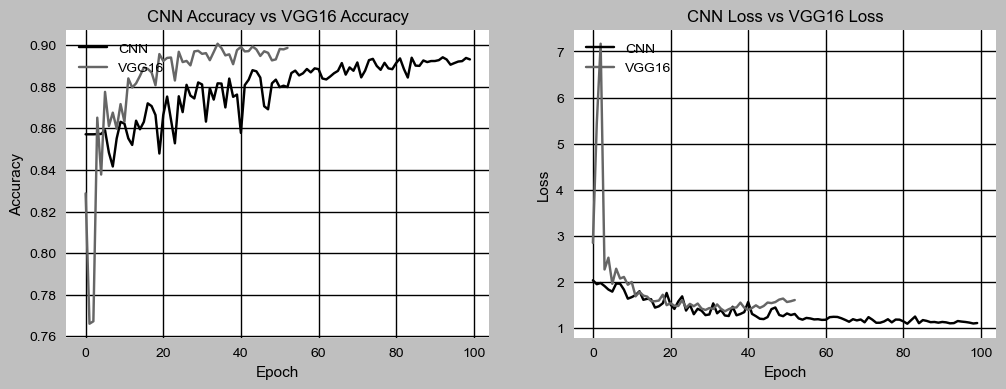

In [48]:
fig , ax = plt.subplots(1,2)
test_acc_CNN = history_CNN.history['Accuracy']
test_acc_VGG16 = history_VGG16.history['Accuracy']
test_loss_CNN = history_CNN.history['loss']
test_loss_VGG16 = history_VGG16.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history_CNN.history['val_Accuracy'])
ax[0].plot(history_VGG16.history['val_Accuracy'])
ax[0].set_title('CNN Accuracy vs VGG16 Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['CNN', 'VGG16'], loc = 'upper left')

ax[1].plot(history_CNN.history['val_loss'])
ax[1].plot(history_VGG16.history['val_loss'])
ax[1].set_title('CNN Loss vs VGG16 Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['CNN', 'VGG16'], loc = 'upper left')

plt.show()